# CNN + Transfer learning 練習

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, GlobalAveragePooling2D)
import tensorflow as tf

## 資料讀入及前處理

In [3]:
df_label = pd.read_csv('/home/jovyan/mid-term/who_is_she/input/classmap.csv')
df_label

,classname,classnum
0,rika,0
1,risa,1
2,yui,2
3,akane,3
4,neru,4


In [4]:
num = df_label.loc[df_label['classname'] == 'rika'].classnum.values[0]
num = num.astype(str)
num

'0'

In [5]:
data_path = "/home/jovyan/mid-term/who_is_she/input/training_set"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots, each))
            class_name = roots.split("/")[-1]
            label = df_label.loc[df_label['classname'] == class_name].classnum.values[0]
            label = label.astype(str)
            y_data_list.append(label)

In [6]:
# y_data_list

In [7]:
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list

In [8]:
data_list.head(3)

,img_path,label
0,/home/jovyan/mid-term/who_is_she/input/trainin...,0
1,/home/jovyan/mid-term/who_is_she/input/trainin...,0
2,/home/jovyan/mid-term/who_is_she/input/trainin...,0


In [9]:
from sklearn.model_selection import train_test_split

train_list, valid_list = train_test_split(data_list,
                                         test_size=0.2,
                                         random_state=35,
                                         stratify=data_list['label'].values)

In [10]:
#train_list

In [11]:
#valid_list

In [12]:
pred_data_path = "/home/jovyan/mid-term/who_is_she/input/testing_set"

x_pred_list = []

for roots, dirs, files in os.walk(pred_data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_pred_list.append(os.path.join(roots, each))


In [13]:
pred_list = pd.DataFrame({})
pred_list['img_path'] = x_pred_list

In [14]:
pred_list.head(3)

,img_path
0,/home/jovyan/mid-term/who_is_she/input/testing...
1,/home/jovyan/mid-term/who_is_she/input/testing...
2,/home/jovyan/mid-term/who_is_she/input/testing...


In [15]:
img_size = 224
num_class = len(data_list['label'].unique())

## 讀入 Pre-trained Model

In [16]:
from tensorflow.keras.applications.resnet import (ResNet50, preprocess_input)

In [17]:
pre_model = ResNet50(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(pre_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=pre_model.inputs, outputs=outputs)

94773248/94765736 [==============================] - 5s 0us/step


In [42]:
# model.summary()

# 決定 Pre-Train 參數量

In [19]:
pre_model.trainable = True

# trainable_layer = 10
# for layer in pre_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

In [20]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Data Augmentation

In [21]:
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 50

In [22]:
train_datagen = ImageDataGenerator(
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input
                                  )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [23]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=valid_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

#用在不知道 label 的資料讀取上
test_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=pred_list,
                                                    directory=pred_data_path,
                                                    x_col="img_path",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    shuffle=False)


Found 430 validated image filenames belonging to 5 classes.
Found 108 validated image filenames belonging to 5 classes.
Found 438 validated image filenames.


## 開始訓練模型

In [24]:
model_dir = 'model-logs/resnet50'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [25]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

Epoch 1/50
14/14 [==============================] - 17s 1s/step - loss: 1.8198 - accuracy: 0.2558 - val_loss: 1.8987 - val_accuracy: 0.2315
Epoch 2/50
14/14 [==============================] - 13s 952ms/step - loss: 1.5580 - accuracy: 0.3186 - val_loss: 1.7270 - val_accuracy: 0.2778
Epoch 3/50
14/14 [==============================] - 13s 935ms/step - loss: 1.3549 - accuracy: 0.4698 - val_loss: 1.5941 - val_accuracy: 0.2963
Epoch 4/50
14/14 [==============================] - 13s 961ms/step - loss: 1.1900 - accuracy: 0.5442 - val_loss: 1.4849 - val_accuracy: 0.3611
Epoch 5/50
14/14 [==============================] - 13s 945ms/step - loss: 1.0995 - accuracy: 0.5953 - val_loss: 1.3954 - val_accuracy: 0.3981
Epoch 6/50
14/14 [==============================] - 13s 926ms/step - loss: 0.9565 - accuracy: 0.6698 - val_loss: 1.3122 - val_accuracy: 0.4630
Epoch 7/50
14/14 [==============================] - 13s 936ms/step - loss: 0.8857 - accuracy: 0.7326 - val_loss: 1.2406 - val_accuracy: 0.5000
Ep

## 訓練結果視覺化

In [26]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)
# model.save('path_to_saved_model', save_format='tf')


4/4 - 1s - loss: 0.7357 - accuracy: 0.7222


In [27]:
# model = keras.models.load_model('./model-logs/basic_model-best-model.h5')
# loss, acc = model.evaluate(x_test, y_test, verbose=2)

In [28]:
y_pred = model.predict_generator(valid_generator)
y_pred = y_pred.argmax(-1)

In [29]:
y_pred

array([1, 2, 0, 1, 2, 0, 0, 3, 1, 1, 1, 3, 3, 2, 4, 2, 3, 4, 3, 1, 4, 2,
       3, 4, 4, 1, 4, 4, 3, 1, 0, 2, 2, 0, 3, 0, 4, 2, 4, 0, 0, 3, 3, 0,
       0, 2, 2, 1, 0, 2, 0, 3, 3, 0, 1, 0, 4, 1, 1, 2, 2, 1, 0, 1, 1, 3,
       4, 3, 1, 4, 2, 3, 2, 4, 2, 1, 0, 4, 1, 3, 0, 4, 0, 0, 4, 2, 1, 4,
       1, 0, 4, 3, 4, 4, 3, 0, 3, 2, 4, 4, 3, 1, 1, 0, 4, 2, 3, 1])

In [30]:
y_test = valid_generator.classes
class_name = valid_generator.class_indices
class_names = np.array([each for each in class_name.keys()])

In [31]:
y_pred

array([1, 2, 0, 1, 2, 0, 0, 3, 1, 1, 1, 3, 3, 2, 4, 2, 3, 4, 3, 1, 4, 2,
       3, 4, 4, 1, 4, 4, 3, 1, 0, 2, 2, 0, 3, 0, 4, 2, 4, 0, 0, 3, 3, 0,
       0, 2, 2, 1, 0, 2, 0, 3, 3, 0, 1, 0, 4, 1, 1, 2, 2, 1, 0, 1, 1, 3,
       4, 3, 1, 4, 2, 3, 2, 4, 2, 1, 0, 4, 1, 3, 0, 4, 0, 0, 4, 2, 1, 4,
       1, 0, 4, 3, 4, 4, 3, 0, 3, 2, 4, 4, 3, 1, 1, 0, 4, 2, 3, 1])

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix

# print(accuracy_score(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

Text(0.5, 1, 'Confusion Matrix')

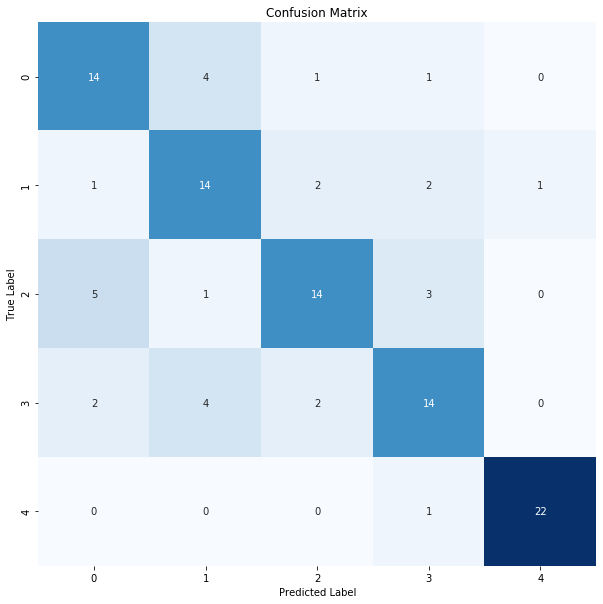

In [33]:
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

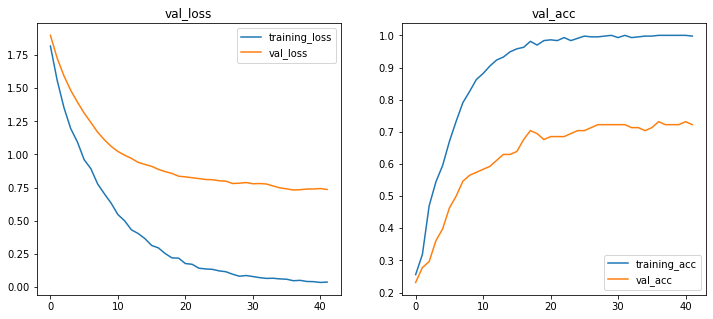

In [40]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title(eachy)
plt.show()

In [35]:
#saveToCSV()
y_pred = model.predict(test_generator)

In [36]:
y_pred = y_pred.argmax(-1)

In [37]:
# path = pred_list['img_path'][0]
# print(path)
# print(path.split('/')[-1].split('.')[0])

In [38]:
count =pred_list.size
i=0
id_array =[]
while(i < count):
    path = pred_list['img_path'][i]
    id_array.append(path.split('/')[-1].split('.')[0])
    i+=1

In [39]:



sub = pd.read_csv('/home/jovyan/mid-term/who_is_she/sample_submission.csv')
    

test_submission = pd.DataFrame({'id':id_array, 'class': y_pred})
test_submission.to_csv('/home/jovyan/mid-term/who_is_she/output/submission.csv',index = False)
